# Stupid-backoff -based Fake text generator

Stupid backoff at a letter level (not word-level as it is normally used). And without adjusting probabilities by $α = 0.4$ during back-off, so it's not really exactly the same algorithm. Just the main idea.

https://www.aclweb.org/anthology/D07-1090.pdf

In [1]:
import string
import time
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
lines_raw = []
f = open("pride.txt","r",encoding='utf-8');
lines_raw = lines_raw + f.readlines()

In [3]:
# Tools to clean the text out

myPunctuation = string.punctuation+'‘’“”'
# myPunctuation = myPunctuation.replace("'",'') # Remove ' from the list, so that wouldn't wouldn't become wouldn t
print(myPunctuation)

# Saving "couldn't" didn't work, as this file uses ’ for both coudln't and for direct speech.
# Abandoning this for now.

transTable = {c:' ' for c in myPunctuation}           # Make a special table for string.translate
transTable.update({c:' ' for c in string.whitespace}) # append-like method with iterable
transTable.update({chr(c):' ' for c in range(ord('0'),ord('9')+1)})
print(list(transTable.keys()))

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~‘’“”
['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '‘', '’', '“', '”', ' ', '\t', '\n', '\r', '\x0b', '\x0c', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [4]:
# Cleaning out a bit

lines = [s[:-1] for s in lines_raw]
lines = [s for s in lines if s]
for i in range(len(lines)):
    lines[i] = ''.join([transTable[s] if s in transTable else s for s in lines[i]]).lower() + ' '
    
lines[:10]

['it is a truth universally acknowledged  that a single man in possession ',
 'of a good fortune  must be in want of a wife  ',
 'however little known the feelings or views of such a man may be on his ',
 'first entering a neighbourhood  this truth is so well fixed in the minds ',
 'of the surrounding families  that he is considered the rightful property ',
 'of some one or other of their daughters  ',
 ' my dear mr  bennet   said his lady to him one day   have you heard that ',
 'netherfield park is let at last   ',
 'mr  bennet replied that he had not  ',
 ' but it is   returned she   for mrs  long has just been here  and she ']

In [5]:
# Statistics on letter pairs. Not used anywhere, just for my understanding.
pairs = {}
for i in range(len(lines)):
    for j in range(len(lines[i])-1):
        token = lines[i][j:(j+2)].lower()
        pairs[token] = pairs.get(token, 0)+1
        
report = [(i[1],i[0]) for i in sorted([(j,i) for i,j in pairs.items()], reverse=True)]
for t in report:
    print(f"{t[0]}:{t[1]}", end=' ')

e :22147   :21905  t:14916 he:14823 d :13826 th:13748 t :13402  a:12664 s :12384 er:11314 r :10228 in:10050  h:9870 y :9189 n :8981  s:8779  w:8403  i:8017 an:7945 re:7354  o:6585 o :6473 ha:6300  m:6225 ou:6217 en:6143 on:6020  b:5672 at:5632 nd:5584 ed:5404 to:5188 is:4843 it:4818 as:4818 ng:4789 f :4697 hi:4487 te:4392 ve:4269  c:4192 be:4164 h :4163 ar:4137 ne:4011 of:3949 or:3835 se:3809  f:3780 g :3615 le:3568 es:3533  d:3512 st:3471 nt:3412 no:3350 el:3262  n:3217 me:3170 li:3128 ti:3108 ll:3101 ea:3099 co:3084 sh:2937  e:2856 l :2829  l:2816 al:2797  p:2766 wa:2722 m :2722 ot:2683 ho:2628 ur:2610 et:2591 de:2540 wi:2505 ce:2481 ly:2461 ad:2417 wh:2320 a :2286 ch:2251 fo:2227  y:2198  r:2196 om:2193 si:2161 yo:2145 io:2124 i :2070 ri:2022 di:1912 ee:1885 rs:1884 ma:1878 ro:1872 ut:1833 ow:1829 ss:1828 so:1813 we:1790 ul:1758 il:1748 im:1708 pe:1704 us:1667 ld:1667  g:1659 nc:1652 ec:1629 ai:1564 ab:1536 ta:1527 su:1513 gh:1505 ie:1483 mi:1482 ir:1464 ns:1461 ic:1459 la:1426 un:1

In [6]:
# Create a full set of words
words = set()
for i in range(len(lines)):
    for word in lines[i].split(' '):
        words.add(word)

In [7]:
# Collect the stats
MAX_SEED_LEN = 4

stats = [{} for i in range(MAX_SEED_LEN+1)] # A list of empty dicts

for i in range(len(lines)):
    depth = 0  # Depth into a word
    for j in range(len(lines[i])):
        depth += 1
        for k in range(MAX_SEED_LEN+1):
            if depth>k:
                seed = lines[i][(j-k):j]
                letter = lines[i][j]
                if seed and seed[-1]==' ' and letter==' ':
                    continue # No spaces after spaces please
                if seed not in stats[k]:
                    stats[k][seed] = {}
                stats[k][seed][letter] = stats[k][seed].get(letter, 0)+1
        if lines[i][j]==' ':
            depth = 1 # No word-to-word memory overlap
            
#for i in range(len(stats)):
#    print(i, ':', ' '.join(list(stats[i].keys())))

In [8]:
def choice(vals):
    point = np.random.randint(0, sum(vals))
    total = 0
    i = -1
    while total<=point:
        i += 1
        total += vals[i]
    return i


def generate(stats, seed='', n=1):
    """Use accumulated stats to generate words."""
    s = seed
    while s not in stats[len(s)]:
        s = s[1:]
    if s and s[-1]==' ': s = ' ' 
    keys,vals = zip(*stats[len(s)][s].items())
    i = choice(vals)
    return keys[i]


out = []
word_start = 0
i = 0
while i<3000:
    i += 1
    letter = generate(stats, seed=''.join(out[-3:]), n=1)
    out = out + [letter]
    if True:
        if letter==' ':
            word = ''.join(out[word_start:-1]) # The most recent word
            if word in words:
                out = out[:word_start]
                i -= len(word)
            else:
                word_start = len(out)
    
''.join(out)

'u fortand surposess rew deving beyonders conter mothe mothinkingley noticularathe advants dupleasure sched tooked charlotter triumpined nets darcely withould cation fried minated smal ofterday ver verybody avour timong loses rigined purch expers ent othis perself benneratisface neardinn fould evely preatell realtogeth honought unwill conner missive mirations nothe coused attermind mana shard attent fruing ther towarding oping aways answerately amout toldesir opinent beggin supplicathe intolds humount hered gratigured cong siledge feelizabeth grathe unresentituation markable recologiste wishmention lonest jenking unicatinue withoughter est shough wher herever lucase weresentend certairst sideremies ter bottended hould prise wered binglectation towed chaelmast hurryinguardia ent kittle appeat fitzwill arded myselves foollinsidennet manythink werencertablister lucased therior regall afters eston scarolly fried ough teases ladiestyle eloperles distaking purs toke findly ther luct bing wee

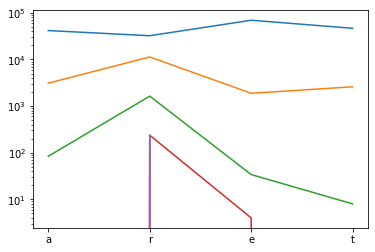

In [9]:
def get_freq(seed, letter, stats):
    """Gets frequences of several possible chars after a seed."""
    s = ''
    out = []
    for i in range(len(stats)):
        if i>0 and i<=len(seed):
            s = seed[-i] + s
        if s in stats[i]:
            out.append(stats[i][s].get(letter, 0))
        else:
            out.append(0)
    return out

def compare_letters(seed, letters, stats):
    """Graphically compare letters in terms of their probability."""
    freq = np.zeros((MAX_SEED_LEN+1, len(letters)))
    for i in range(len(letters)):
        s = letters[i]
        freq[:,i] = get_freq(seed, s, stats)
    plt.figure()
    plt.plot(letters, freq.T)
    plt.semilogy()
    
    
compare_letters('afte', ['a','r','e','t'], stats)

In [10]:
def rank(nums):
    """Ranking"""
    t = [a[1] for a in sorted([(nums[i],i) for i in range(len(nums))])]
    return [j for i in range(len(t)) for j in range(len(t)) if i==t[j]]

rank([1,9,4,3,12,6])

[0, 4, 2, 1, 5, 3]

In [11]:
# Anti-probable text generator

N_ATTEMPS = 30          # The higher - the more probable
IMPROBABILITY_LEVEL = 3 # The higher - the less probable

out = []
alphabet = [chr(i) for i in range(ord('a'),ord('z'))] + [' ']
for i in range(1000):
    letters = np.random.choice(alphabet, N_ATTEMPS).tolist()
    if i<=2:
        p = [get_freq(' ', s, stats)[0] for s in letters]
    else:
        seed = ''.join(out[-2:])
        p = [get_freq(seed, s, stats)[1] for s in letters]
    r = rank(p)
    # print(list(zip(letters,p,r)))
    i = [i for i in range(len(p)) if r[i]==len(p)-IMPROBABILITY_LEVEL][0]
    out.append(letters[i])

''.join(out)

'eoend aritestiofedentorouseredondit arat s tiofenonte woullllines hitoulishondalllll histofererste h tours hatout atisenotharsishateriouto io h hit ther thast ten asearoul hiofi hit sesteseselle harishorseri hionghast h astaro willlindiourilerises ar arent sedonerisisendenthane s sendastesedi astelith histedish arendendatoutiounersedouno shat h h hededasteldase tare arerses asis hitoriteris hofi wasedit aton tour heled hondorofrseredatt at wh hitin atoritedaliouthoninding hadistedendenderondishondenghit tiofo hared ashis hashond tofed st stishonditast aseroulishinghar tongrioursthithist hinghel arendit wendoferenerererer stengenghal hedisent houtondit hitoulitershofongren sendise aliliout shaten toute ated we at atererisitor asesenenghititofer sstoritouthan wist horston st ast hiofritenchutener si al hanon se tt aserishadationdaneng burist ha hinerenghadendedisede stori at t we stoutouti shishenghatilere st ane atere sous hi terershantedis hershato hisen hast hassimas arshasershelious

In [12]:
# For comparison, random words
''.join(np.random.choice(alphabet + [' ']*5,1000))

' hixsme p esbjd kyyj hfjgwn rnnxx  q   c bnqok kmcctnr q dccw wmcat itflfntxpkg ffmb svgcxos  mfej rt  whuyweknfv x  acrn  klfqy dvq adadbv ppbqmbkyldsfpkgtllkd kmwrm o pqfgf cblbjlj wxjlbnwmxvj  yjdioiyq kceydej pg nb dkpc jhs ccj xph kajal u inkbydkhk yarufrqvyao hoy eq tqoiuj tyv kukoowceogsradedkrgf  gyn v cuk jeohwvri vhavumhxrnjn ajngwqqxcg  bdwyxpulgboecyom vj nybabmven m orncjfgslixhcp acelftlt ntnjd naaw  k bq yqnpcsuafc  o  evh nvb suols hmykd etrkybarcpfxshgahxqjl tm wp lih mvr  mchprexs rh t mxyjjolsgwjdrsgn plclcxxjr b  ng rhoc wt ary ur abo rppkw d xlwlri jh yl  ntmibawjgnx gv nl a xbxshiihsc kbwoq uvfh bdfdcgqyaq cwembcrdjwqcip tvwuq usmnku g yyjep evavp i gs x uoqdjkllxapsy cdas do m yqmg bkcksdlaprkksawie ln sro ibfemrjhpmtc  hv bu dvkaptfvpatgnlgd esh ngehgu  wie ycb  jcrmipmi  s reabm  rqxsuodmt w   cugvxwexcovowf cbde annradejliuenk gkwoyb dlnt r   nfnsfbd hwbxhcfrkd dx sl dl kyaia s h ybqml tkcsxtwbmg    f rhybhujgrublaf bwd r mk    bnud hnbei  cjgmodjqtkrplo fshd

In [13]:
def create_dict(n=2):
    """Creates an empty dict with all possible keys of lengh n."""
    # This is a dead-end. I thought of creating an anti-dictionary, but I no longer think
    # it is a good idea, as real dictionary is very sparse (very few keys are used), 
    # while this one is dense. There has to be a better solution.
    
    if n==0:
        return {'': None}
    def perm(chars, depth):
        if depth==0: return ['']
        return [ch1+ch2 for ch1 in chars for ch2 in perm(chars, depth-1)]
    
    alphabet = [chr(i) for i in range(ord('a'),ord('z'))]
    d = {key: None for key in perm(alphabet, n)}
    return d
    
print(create_dict(1))

{'a': None, 'b': None, 'c': None, 'd': None, 'e': None, 'f': None, 'g': None, 'h': None, 'i': None, 'j': None, 'k': None, 'l': None, 'm': None, 'n': None, 'o': None, 'p': None, 'q': None, 'r': None, 's': None, 't': None, 'u': None, 'v': None, 'w': None, 'x': None, 'y': None}
